<a href="https://colab.research.google.com/github/obeabi/AirlineSentiment/blob/main/Airline_CNN_BertTok_BertEmbedLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Sentiment Dataset
## Written by Abiola Obembe
### Date: 2020-12-31

### Goal: Train a classifiier to predict customer sentiment from customer review text (using Bert tokenizer and embedding layer)


A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Step 1: Data Cleaning and Preprocessing

In [204]:
# install BERT library
!pip install bert-for-tf2
!pip install sentencepiece

print("Packages installed!")

Packages installed!


In [205]:
# Install tensorflow
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import random
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import  BeautifulSoup

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


print("installation complete!")
print(tf.__version__)


installation complete!
2.4.0


In [206]:
# Import dataset
dataset = pd.read_csv('Tweets.csv', encoding= 'latin1', engine='python', quoting = 1)

dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [207]:
# Drop columns not required
dataset.drop(columns = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence',
                        'airline', 'airline_sentiment_gold','name','negativereason_gold','retweet_count','tweet_coord',
                        'tweet_created','tweet_location','user_timezone'], axis = 1, inplace = True)
dataset.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn'tâ¦but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [208]:
#  Investigate the number of distinct sentiments
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

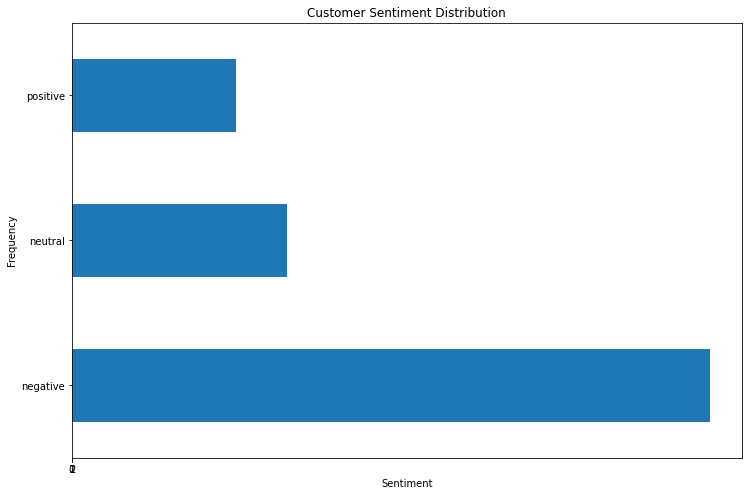

In [209]:
# Lets visualize the sentiments
count_classes = pd.value_counts(dataset['airline_sentiment'], sort = True)
count_classes.plot(kind = 'barh', rot = 0)
plt.title("Customer Sentiment Distribution")
plt.xticks(range(3))
plt.xlabel("Sentiment")
plt.ylabel('Frequency')
plt.show()

In [210]:
# Let us check for missing values in both columns
print(dataset.isnull().sum())

missing_values = dataset.isnull().sum().sum()
print('The total number of missing values in the dataframe is' , str(missing_values))

airline_sentiment    0
text                 0
dtype: int64
The total number of missing values in the dataframe is 0


In [212]:
## Data Cleaning
def clean_tweet(tweet):

    tweet = BeautifulSoup(tweet, "lxml").get_text()
    # Removing the @
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    # Removing the URL links
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    # Keeping only letters
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
    # Removing additional whitespaces
    tweet = re.sub(r" +", ' ', tweet)
    return tweet
  

In [213]:
# Let's examine the corpus
data_clean = [clean_tweet(tweet) for tweet in dataset.text]

In [216]:
# Let us encode the labels into integers 
from sklearn import preprocessing 
  
# label_encoder 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
dataset['airline_sentiment']= label_encoder.fit_transform(dataset['airline_sentiment']) 
dataset['text']= data_clean
dataset['airline_sentiment'].unique() 

array([1, 2, 0])

In [217]:
dataset.head()

,airline_sentiment,text
0,1,What said.
1,2,plus you've added commercials to the experien...
2,1,I didn't today... Must mean I need to take an...
3,0,it's really aggressive to blast obnoxious ent...
4,0,and it's a really big bad thing about it


## STEP 2: Tokenization with BERT

In [218]:
# Tokenization: BERT
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)


In [228]:
# Create function to tokenize text
def encode_sentence(sent):
  return ["[CLS]"] + tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent)) + ["[SEP]"]

In [230]:
# create data-input and data labels
data_inputs = [encode_sentence(sentence) for sentence in data_clean ]
data_labels = dataset.airline_sentiment.values

In [232]:
# Let's examine the tokenizer in action
encode_sentence("Dogs loves bones but hates oranges.")

['[CLS]', 6077, 7459, 5944, 2021, 16424, 4589, 2015, 1012, '[SEP]']

### Dataset Creation

In [222]:
def get_ids(tokens):
    return tokenizer.convert_tokens_to_ids(tokens)

def get_mask(tokens):
    return np.char.not_equal(tokens, "[PAD]").astype(int)

def get_segments(tokens):
    seg_ids = []
    current_seg_id = 0
    for tok in tokens:
        seg_ids.append(current_seg_id)
        if tok == "[SEP]":
            current_seg_id = 1-current_seg_id # turns 1 into 0 and vice versa
    return seg_ids

In [223]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7]

KeyError: ignored

In [224]:
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types = (tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes= ((None,), ()   ))

In [225]:
# Inspect dataset
next(iter(all_batched))

InvalidArgumentError: ignored

In [226]:
# split dataset into train and test set
import math
NB_BATCHES = math.ceil(len(sorted_all)/BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES// 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

In [227]:
my_sent = ["[CLS]"] + tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Roses are red.")) + ["[SEP]"]
bert_layer([tf.expand_dims(tf.cast(get_ids(my_sent),tf.int32),0),
            tf.expand_dims(tf.cast(get_mask(my_sent),tf.int32),0),
            tf.expand_dims(tf.cast(get_segments(my_sent),tf.int32),0)])

KeyError: ignored

# Step 4: Build the Model

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3', trainable= False)

        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding="valid", activation="relu")
        
        self.trigram = layers.Conv1D(filters=nb_filters,kernel_size=3, padding="valid", activation="relu")
        
        self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding="valid", activation="relu")
        
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)

        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1, activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes, activation="softmax")


    def embed_with_bert(self,all_token):
       _,embs = self.bert_layer([all_tokens[:,0,:],
                                 all_tokens[:,1,:],
                                 all_tokens[:,2,:]])
       return embs

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs)
        
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [ ]:
# Configuration details
VOCAB_SIZE = len(tokenizer.vocab)

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 3

DROPOUT_RATE = 0.25

NB_EPOCHS = 10

In [ ]:
# Let's DEFINE THE LOSS for the model
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [ ]:
# Create a checkpoint
checkpoint_path = "./drive/My Drive/projects/Bert_for_NLP/ckpt/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")



In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

   def on_epoch_end(self, epoch, logs = None):
     ckpt_manager.save()
     print("Checkpoint saved at {}. ".format(checkpoint_path))

In [ ]:
# train model
Dcnn.fit(train_dataset,epochs=NB_EPOCHS, callbacks= [MyCustomCallback()])

In [ ]:
# Evaluate model
results = Dcnn.evaluate(test_dataset)
print(results)

In [ ]:
# Make predictions
def get_prediction(sentence):
  tokens = encode_sentence(sentence)
  inputs = tf.expand_dims(tokens, 0)

  output = Dcnn(inputs, training= False)
  sentiment = output

  for i in range(len(sentiment)):
    if np.argmax(sentiment) == 0:
      print("The sentiment is negative")

    elif np.argmax(sentiment) == 1:
      print("The sentiment is neutral")

    else:
        print('The sentiment is positive')


In [ ]:
x= get_prediction("The food was lovely.")
